In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt

import math 
import json
import datetime
import calendar

from scipy.stats import linregress, kurtosis, skew
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; } .CodeMirror pre {font-size: 9pt;}</style>"))

In [ ]:
# rec_start_times = [1658332442.98, 1658345314.37, 1658345729.36, 1658346131.27, 1658346471.61, 1658702642.16, 1658804726.89, 1658805067.11, 1658805409.22, 1658805752.41, 1658807518.46, 1658807890.06, 1658808235.77, 1658808649.14, 1658822742.70, 1658823614.21, 1658823960.59] #[1659121164.33, 1659300482.76, 1659301392.51, 1659302803.53, 1659303160.13] 
# rec_end_times   = [1658332773.02, 1658345614.42, 1658346029.40, 1658346431.30, 1658346771.65, 1658702942.19, 1658805026.94, 1658805367.14, 1658805709.25, 1658806052.45, 1658807818.50, 1658808190.10, 1658808535.82, 1658808949.18, 1658823042.74, 1658823914.26, 1658824260.64] #[1659121464.38, 1659300782.79, 1659301692.55, 1659303103.56, 1659303460.17]  

rec_start_times = [1676753192.049, 1676252302.579, 1676221667.302, 1676250308.108, 1676251012.984, 1676253116.447, 1676262981.575, 1676263686.335, 1676430831.076, 1676749883.028, 1676751152.097] 
rec_end_times  =  [1676753492.273, 1676252602.834, 1676221967.506, 1676250608.342, 1676251313.205, 1676253416.679, 1676263281.813, 1676263986.577, 1676431131.31,  1676750183.24,  1676751452.332]
nrecs = len(rec_start_times)
print(nrecs)

nrounds = 5
trial_len = 30000 
# sample_interval = 20

11


In [ ]:
recs = []

for i in range(nrecs):
  print(i)
  df1 = pd.read_csv('./'+str(i+1)+'L.csv')
  df2 = pd.read_csv('./'+str(i+1)+'R.csv')

  df1.drop(df1[(df1.timestamp < rec_start_times[i]-10) | (df1.timestamp > rec_end_times[i])].index, inplace=True)
  df2.drop(df2[(df2.timestamp < rec_start_times[i]-10) | (df2.timestamp > rec_end_times[i])].index, inplace=True)  

  # display(df1)
  # display(df2)

  df1.rename(columns={'timestamp':'timestamp_L', 'ms_device':'ms_device_L', 'ambient':'ambient_L',	'740nm10mm':'740nm10mm_L', '940nm10mm':'940nm10mm_L',	'850nm10mm':'850nm10mm_L',	'740nm27mm':'740nm27mm_L',	'940nm27mm':'940nm27mm_L',	'850nm27mm':'850nm27mm_L'}, inplace=True)
  df2.rename(columns={'timestamp':'timestamp_R', 'ms_device':'ms_device_R', 'ambient':'ambient_R',	'740nm10mm':'740nm10mm_R', '940nm10mm':'940nm10mm_R',	'850nm10mm':'850nm10mm_R',	'740nm27mm':'740nm27mm_R',	'940nm27mm':'940nm27mm_R',	'850nm27mm':'850nm27mm_R'}, inplace=True)
  
  df1['datetime_L'] = pd.to_datetime(df1.timestamp_L, unit='s')
  df1.set_index('datetime_L', inplace=True)

  df2['datetime_R'] = pd.to_datetime(df2.timestamp_R, unit='s')
  df2.set_index('datetime_R', inplace=True)

  
  # display(df1)
  # display(df2)


  df = pd.concat([df1,df2], axis=1)
  df.interpolate(method='index', axis=0, inplace=True)
  df.reset_index(inplace=True)
  
  df.drop(df[df.index%2 == 0].index, inplace=True)
  df.drop('timestamp_R', axis=1, inplace=True)
  df.rename(columns={'timestamp_L': 'timestamp', 'index':'datetime'}, inplace=True)
  df.timestamp -= rec_start_times[i] #df.timestamp.values[0]

  display(df)
  recs.append(df)

0


datetime   timestamp    ms_device_L     ambient_L  \
1     2023-02-18 20:46:22.062786048   -9.986214  119048.074239  4.670403e+06   
3     2023-02-18 20:46:22.101516032   -9.947484  119080.000000  4.669954e+06   
5     2023-02-18 20:46:22.141516032   -9.907484  119120.000000  4.677508e+06   
7     2023-02-18 20:46:22.181516032   -9.867484  119160.000000  4.669888e+06   
9     2023-02-18 20:46:22.211427072   -9.837573  119200.000000  4.685361e+06   
...                             ...         ...            ...           ...   
16379 2023-02-18 20:51:32.097763072  300.048763  446600.000000  4.691574e+06   
16381 2023-02-18 20:51:32.137763072  300.088763  446640.000000  4.691680e+06   
16383 2023-02-18 20:51:32.169081088  300.120081  446688.314112  4.691618e+06   
16385 2023-02-18 20:51:32.209080832  300.160081  446728.313856  4.691724e+06   
16387 2023-02-18 20:51:32.249080832  300.191767  446760.000000  4.691686e+06   

         740nm10mm_L    940nm10mm_L    850nm10mm_L   740nm27mm_L  \
1      207610.450111  411150.011580  493063.642687  4.841136e+06   
3      207632.000000  411241.000000  493082.000000  4.844955e+06   
5      207438.000000  411397.000000  492991.000000  4.839997e+06   
7      207724.000000  411340.000000  492881.000000  4.844262e+06   
9      207650.000000  411221.000000  492912.000000  4.841057e+06   
...              ...            ...            ...           ...   
16379  208223.000000  397171.000000  475987.000000  4.864448e+06   
16381  208027.000000  396950.000000  475666.000000  4.861821e+06   
16383  208051.778413  396790.094726  475946.381107  4.864708e+06   
16385  208212.454925  396864.733722  476035.137728  4.861942e+06   
16387  208218.000000  396959.000000  476150.000000  4.865815e+06   

        940nm27mm_L   850nm27mm_L   ms_device_R     ambient_R    740nm10mm_R  \
1      4.966033e+06  4.836015e+06  6.811200e+05  4.746814e+06  224420.000000   
3      4.969487e+06  4.836334e+06  6.811769e+05  4.746830e+06  224571.170228   
5      4.964134e+06  4.840229e+06  6.812169e+05  4.746734e+06  224379.182976   
7      4.970084e+06  4.837179e+06  6.812571e+05  4.746753e+06  224289.982287   
9      4.963498e+06  4.838594e+06  6.812873e+05  4.746641e+06  224437.544826   
...             ...           ...           ...           ...            ...   
16379  4.976037e+06  4.851594e+06  1.008690e+06  4.761193e+06  225230.476400   
16381  4.980617e+06  4.857753e+06  1.008730e+06  4.761168e+06  225210.186750   
16383  4.977188e+06  4.846296e+06  1.008760e+06  4.761255e+06  225381.000000   
16385  4.979058e+06  4.856747e+06  1.008800e+06  4.761532e+06  225192.000000   
16387  4.978525e+06  4.852082e+06  1.008840e+06  4.761340e+06  225270.000000   

         940nm10mm_R    850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      602521.000000  966853.000000  4.824999e+06  4.859969e+06  4.852690e+06  
3      602672.011078  966601.447606  4.824496e+06  4.859443e+06  4.852801e+06  
5      602282.599616  966408.123366  4.824191e+06  4.859753e+06  4.852301e+06  
7      602270.555166  966498.316899  4.824096e+06  4.859536e+06  4.852337e+06  
9      602541.090240  966686.084205  4.824649e+06  4.859588e+06  4.852645e+06  
...              ...            ...           ...           ...           ...  
16379  592923.964218  954969.423716  4.793470e+06  4.873764e+06  4.879273e+06  
16381  592623.167092  954392.716056  4.798536e+06  4.871251e+06  4.878558e+06  
16383  592776.000000  954819.000000  4.794416e+06  4.871270e+06  4.878408e+06  
16385  593106.000000  955504.000000  4.791440e+06  4.872702e+06  4.878992e+06  
16387  593558.000000  956249.000000  4.797157e+06  4.871657e+06  4.878995e+06  

[8194 rows x 18 columns]

1


datetime   timestamp  ms_device_L  ambient_L  \
1     2023-02-13 01:38:12.600065024   -9.978935     412640.0  4708996.0   
3     2023-02-13 01:38:12.640065024   -9.938935     412680.0  4708889.0   
5     2023-02-13 01:38:12.678006016   -9.900994     412720.0  4708725.0   
7     2023-02-13 01:38:12.718006016   -9.860994     412760.0  4709125.0   
9     2023-02-13 01:38:12.758006016   -9.820994     412800.0  4709120.0   
...                             ...         ...          ...        ...   
16381 2023-02-13 01:43:22.669714944  300.090715     740240.0  4708684.0   
16383 2023-02-13 01:43:22.709714944  300.130715     740280.0  4708667.0   
16385 2023-02-13 01:43:22.749003008  300.170003     740320.0  4708333.0   
16387 2023-02-13 01:43:22.789003008  300.210003     740360.0  4708385.0   
16389 2023-02-13 01:43:22.829002752  300.250003     740400.0  4708488.0   

       740nm10mm_L  940nm10mm_L  850nm10mm_L  740nm27mm_L  940nm27mm_L  \
1         221815.0     473585.0     644251.0    4875393.0    4991971.0   
3         221518.0     471630.0     640879.0    4874487.0    4990218.0   
5         221475.0     468633.0     635032.0    4874571.0    4988026.0   
7         221327.0     467810.0     633728.0    4875027.0    4987013.0   
9         221317.0     467894.0     633915.0    4874833.0    4987674.0   
...            ...          ...          ...          ...          ...   
16381     220608.0     464422.0     622382.0    4872561.0    4988334.0   
16383     220456.0     463993.0     622223.0    4873050.0    4987925.0   
16385     220812.0     464371.0     622194.0    4873001.0    4987502.0   
16387     220565.0     464556.0     622712.0    4872899.0    4988440.0   
16389     220890.0     464873.0     623732.0    4872609.0    4989003.0   

       850nm27mm_L    ms_device_R     ambient_R    740nm10mm_R    940nm10mm_R  \
1        4906322.0  412617.401088  4.772408e+06  205448.067693  420643.756986   
3        4904030.0  412657.401088  4.772445e+06  205603.621229  420607.130131   
5        4898587.0  412695.555930  4.772432e+06  205771.500928  420110.490467   
7        4897407.0  412735.891968  4.772409e+06  205761.678042  419330.874918   
9        4898006.0  412775.891968  4.772320e+06  205685.989338  418938.039808   
...            ...            ...           ...            ...            ...   
16381    4896800.0  740217.634048  4.772862e+06  205545.194035  420110.406835   
16383    4897128.0  740257.634048  4.772995e+06  205541.010221  420246.891923   
16385    4896956.0  740297.110243  4.772922e+06  205500.425957  420235.230101   
16387    4897816.0  740337.361920  4.772863e+06  205528.307968  420224.783616   
16389    4898299.0  740360.000000  4.772935e+06  205693.000000  420291.000000   

         850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      642613.683482  4.786544e+06  4.885504e+06  4.918452e+06  
3      642569.847738  4.786900e+06  4.885620e+06  4.918575e+06  
5      641829.041336  4.787228e+06  4.885499e+06  4.918494e+06  
7      640461.792486  4.793327e+06  4.885645e+06  4.919645e+06  
9      639665.672358  4.806748e+06  4.885912e+06  4.921527e+06  
...              ...           ...           ...           ...  
16381  643677.975366  4.778085e+06  4.880761e+06  4.904864e+06  
16383  643712.411866  4.778088e+06  4.880481e+06  4.904701e+06  
16385  643510.000000  4.778127e+06  4.880447e+06  4.905029e+06  
16387  643562.953856  4.778141e+06  4.880929e+06  4.905179e+06  
16389  643632.000000  4.778394e+06  4.881170e+06  4.905358e+06  

[8195 rows x 18 columns]

2


datetime   timestamp    ms_device_L     ambient_L  \
1     2023-02-12 17:07:37.325465088   -9.976535  603240.000000  4.691057e+06   
3     2023-02-12 17:07:37.349872896   -9.952127  603280.000000  4.690607e+06   
5     2023-02-12 17:07:37.389872896   -9.912127  603320.000000  4.690874e+06   
7     2023-02-12 17:07:37.429872640   -9.872127  603360.000000  4.690732e+06   
9     2023-02-12 17:07:37.470597888   -9.831402  603400.000000  4.690660e+06   
...                             ...         ...            ...           ...   
16379 2023-02-12 17:12:47.323330048  300.021330  930812.999936  4.695089e+06   
16381 2023-02-12 17:12:47.363329792  300.061330  930853.082150  4.695071e+06   
16383 2023-02-12 17:12:47.403330048  300.101330  930893.252096  4.695194e+06   
16385 2023-02-12 17:12:47.430077952  300.128078  930920.000000  4.695115e+06   
16387 2023-02-12 17:12:47.470077952  300.168078  930960.000000  4.694880e+06   

         740nm10mm_L    940nm10mm_L    850nm10mm_L   740nm27mm_L  \
1      203350.000000  337067.000000  369834.000000  4.854505e+06   
3      203688.000000  336702.000000  369502.000000  4.854531e+06   
5      203266.000000  336699.000000  369745.000000  4.854731e+06   
7      203614.000000  337005.000000  369998.000000  4.854441e+06   
9      203690.000000  337387.000000  370842.000000  4.855108e+06   
...              ...            ...            ...           ...   
16379  203345.799962  336616.849331  370585.823686  4.860201e+06   
16381  203431.335394  337043.557756  371379.076289  4.858897e+06   
16383  203651.193459  337456.293235  371902.142426  4.858353e+06   
16385  203807.000000  337689.000000  371965.000000  4.857288e+06   
16387  203274.000000  335723.000000  369222.000000  4.858692e+06   

        940nm27mm_L   850nm27mm_L    ms_device_R     ambient_R    740nm10mm_R  \
1      4.956563e+06  4.806689e+06  272856.037120  4.839718e+06  212456.935040   
3      4.956339e+06  4.805049e+06  272880.752015  4.842753e+06  212418.008059   
5      4.956732e+06  4.805006e+06  272936.779008  4.838627e+06  212531.794054   
7      4.957174e+06  4.806891e+06  272976.778752  4.835371e+06  212522.755725   
9      4.956961e+06  4.808485e+06  273017.241923  4.830341e+06  212567.568164   
...             ...           ...            ...           ...            ...   
16379  4.960449e+06  4.817791e+06  600400.000000  4.868055e+06  212501.000000   
16381  4.963724e+06  4.815438e+06  600440.000000  4.871610e+06  212507.000000   
16383  4.965419e+06  4.820012e+06  600480.000000  4.872322e+06  212592.000000   
16385  4.965072e+06  4.829614e+06  600536.555008  4.871175e+06  212553.081446   
16387  4.962123e+06  4.821611e+06  600576.555008  4.869721e+06  212427.868390   

         940nm10mm_R    850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      483137.612992  768578.707680  4.911108e+06  5.010477e+06  5.115602e+06  
3      483142.728736  768396.185321  4.911294e+06  5.011015e+06  5.116833e+06  
5      483047.086061  768599.030093  4.911255e+06  5.008806e+06  5.114419e+06  
7      483156.872563  768507.245978  4.911104e+06  5.008643e+06  5.115879e+06  
9      483203.363278  768751.814815  4.911234e+06  5.009143e+06  5.117968e+06  
...              ...            ...           ...           ...           ...  
16379  482094.000000  767783.000000  4.941818e+06  5.046351e+06  5.162641e+06  
16381  482427.000000  768060.000000  4.941650e+06  5.042868e+06  5.161669e+06  
16383  482203.000000  768211.000000  4.941621e+06  5.047211e+06  5.161266e+06  
16385  482437.693760  768302.246387  4.941417e+06  5.047218e+06  5.161803e+06  
16387  482453.342118  768335.516749  4.941199e+06  5.044755e+06  5.162274e+06  

[8194 rows x 18 columns]

3


datetime   timestamp    ms_device_L     ambient_L  \
1     2023-02-13 01:04:58.148210944   -9.959789  195760.000000  4.679200e+06   
3     2023-02-13 01:04:58.188210944   -9.919789  195800.000000  4.679349e+06   
5     2023-02-13 01:04:58.214498048   -9.893502  195826.287104  4.679615e+06   
7     2023-02-13 01:04:58.240013056   -9.867987  195880.000000  4.679692e+06   
9     2023-02-13 01:04:58.280013056   -9.827987  195920.000000  4.679614e+06   
...                             ...         ...            ...           ...   
16379 2023-02-13 01:10:08.163738112  300.055738  523320.000000  4.696563e+06   
16381 2023-02-13 01:10:08.201721088  300.093721  523360.000000  4.696532e+06   
16383 2023-02-13 01:10:08.241721088  300.133721  523400.000000  4.696370e+06   
16385 2023-02-13 01:10:08.281721088  300.173721  523440.000000  4.696598e+06   
16387 2023-02-13 01:10:08.307634176  300.199634  523480.000000  4.696861e+06   

       740nm10mm_L    940nm10mm_L    850nm10mm_L   740nm27mm_L   940nm27mm_L  \
1         211872.0  496644.000000  647756.000000  4.827490e+06  4.974476e+06   
3         211837.0  496777.000000  647760.000000  4.828003e+06  4.975433e+06   
5         211837.0  496686.309491  647593.734067  4.827609e+06  4.975587e+06   
7         211973.0  496835.000000  648108.000000  4.827170e+06  4.975473e+06   
9         212041.0  496908.000000  648164.000000  4.827846e+06  4.975693e+06   
...            ...            ...            ...           ...           ...   
16379     211744.0  481853.000000  630648.000000  4.841147e+06  4.985606e+06   
16381     211816.0  481790.000000  631140.000000  4.840512e+06  4.986307e+06   
16383     211691.0  482001.000000  631294.000000  4.841777e+06  4.986635e+06   
16385     211704.0  482017.000000  631279.000000  4.841133e+06  4.986442e+06   
16387     211863.0  482127.000000  631290.000000  4.842163e+06  4.986629e+06   

        850nm27mm_L    ms_device_R     ambient_R    740nm10mm_R  \
1      4.867947e+06   66193.391872  4.718766e+06  203951.880333   
3      4.868399e+06   66233.391872  4.718994e+06  204132.107002   
5      4.868647e+06   66280.000000  4.719280e+06  204153.000000   
7      4.869268e+06   66305.515008  4.718982e+06  204100.694234   
9      4.869897e+06   66345.515008  4.718918e+06  204159.664653   
...             ...            ...           ...            ...   
16379  4.886766e+06  393744.394103  4.752029e+06  205595.855089   
16381  4.887592e+06  393782.781184  4.752208e+06  205616.336390   
16383  4.887272e+06  393822.781476  4.752283e+06  205555.629019   
16385  4.886869e+06  393877.764057  4.751964e+06  205688.578167   
16387  4.887689e+06  393904.564381  4.752044e+06  205769.937939   

         940nm10mm_R    850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      447335.581786  676073.217888  4.747578e+06  4.832395e+06  4.871381e+06  
3      447214.972026  675932.075763  4.746680e+06  4.832622e+06  4.872004e+06  
5      447185.000000  676124.000000  4.745878e+06  4.832814e+06  4.872328e+06  
7      447379.551936  676157.169510  4.745245e+06  4.832704e+06  4.872256e+06  
9      447463.209242  676102.006477  4.742179e+06  4.832985e+06  4.872626e+06  
...              ...            ...           ...           ...           ...  
16379  437852.788205  670357.778495  4.757608e+06  4.861128e+06  4.899529e+06  
16381  437974.555206  670737.792416  4.758502e+06  4.860808e+06  4.899965e+06  
16383  438012.814545  670586.410354  4.758260e+06  4.860670e+06  4.899922e+06  
16385  437894.645756  670738.752366  4.757318e+06  4.861127e+06  4.899677e+06  
16387  438061.564778  671053.930246  4.760005e+06  4.860527e+06  4.899938e+06  

[8194 rows x 18 columns]

4


datetime   timestamp    ms_device_L     ambient_L  \
1     2023-02-13 01:16:43.003969792   -9.980030  411577.110784  4.706203e+06   
3     2023-02-13 01:16:43.041904128   -9.942096  411611.464521  4.706058e+06   
5     2023-02-13 01:16:43.081904128   -9.902096  411642.552304  4.705782e+06   
7     2023-02-13 01:16:43.121903872   -9.862096  411682.551808  4.706274e+06   
9     2023-02-13 01:16:43.159352064   -9.824648  411720.000000  4.705882e+06   
...                             ...         ...            ...           ...   
16379 2023-02-13 01:21:53.053904896  300.069905  739155.265792  4.707312e+06   
16381 2023-02-13 01:21:53.093904640  300.109905  739195.265536  4.707232e+06   
16383 2023-02-13 01:21:53.113690880  300.129691  739215.357050  4.707260e+06   
16385 2023-02-13 01:21:53.153690880  300.169691  739255.846912  4.707301e+06   
16387 2023-02-13 01:21:53.193690880  300.193844  739280.000000  4.707277e+06   

         740nm10mm_L    940nm10mm_L    850nm10mm_L   740nm27mm_L  \
1      205024.901914  369638.650810  433284.246963  4.855460e+06   
3      204951.188734  369607.221946  433283.980395  4.855323e+06   
5      205099.468618  369725.959258  433769.472848  4.855071e+06   
7      205090.141811  370595.675738  434561.947981  4.856184e+06   
9      205283.000000  371310.000000  435970.000000  4.855610e+06   
...              ...            ...            ...           ...   
16379  204716.060192  365034.550925  424650.736640  4.855438e+06   
16381  204735.975706  364358.588992  423384.190131  4.856042e+06   
16383  204845.579716  364336.089066  423473.088022  4.856264e+06   
16385  204972.609510  364619.422323  424089.471206  4.856792e+06   
16387  204908.000000  364963.000000  424520.000000  4.857280e+06   

        940nm27mm_L   850nm27mm_L    ms_device_R     ambient_R    740nm10mm_R  \
1      4.953289e+06  4.800549e+06  411480.000000  4.763405e+06  207684.000000   
3      4.953512e+06  4.800992e+06  411520.000000  4.763682e+06  207543.000000   
5      4.953903e+06  4.801677e+06  411560.000000  4.763957e+06  207692.000000   
7      4.954714e+06  4.801908e+06  411600.000000  4.763864e+06  207345.000000   
9      4.954946e+06  4.803360e+06  411652.465152  4.763740e+06  207687.111514   
...             ...           ...            ...           ...            ...   
16379  4.956065e+06  4.805128e+06  739040.000000  4.768324e+06  207527.000000   
16381  4.955553e+06  4.803350e+06  739080.000000  4.768372e+06  207649.000000   
16383  4.955718e+06  4.803683e+06  739120.000000  4.768480e+06  207700.000000   
16385  4.956006e+06  4.804764e+06  739160.000000  4.768169e+06  207788.000000   
16387  4.955965e+06  4.805184e+06  739200.000000  4.768721e+06  207783.000000   

         940nm10mm_R   850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      450207.000000  698532.00000  4.769510e+06  4.875183e+06  4.897377e+06  
3      449900.000000  698276.00000  4.769975e+06  4.874584e+06  4.897220e+06  
5      449924.000000  697886.00000  4.769375e+06  4.874854e+06  4.896550e+06  
7      449818.000000  698037.00000  4.769996e+06  4.875185e+06  4.897100e+06  
9      449812.395072  698154.34409  4.769812e+06  4.875280e+06  4.897812e+06  
...              ...           ...           ...           ...           ...  
16379  446864.000000  694323.00000  4.774961e+06  4.879407e+06  4.901365e+06  
16381  446389.000000  694030.00000  4.777386e+06  4.879291e+06  4.900186e+06  
16383  446313.000000  693821.00000  4.780255e+06  4.879218e+06  4.898974e+06  
16385  446303.000000  693678.00000  4.778746e+06  4.879221e+06  4.899635e+06  
16387  446382.000000  693729.00000  4.775676e+06  4.880025e+06  4.900523e+06  

[8194 rows x 18 columns]

5


datetime   timestamp    ms_device_L     ambient_L  \
1     2023-02-13 01:51:46.483737088   -9.963263  526680.000000  4.708282e+06   
3     2023-02-13 01:51:46.520370944   -9.926629  526734.778880  4.708928e+06   
5     2023-02-13 01:51:46.550441984   -9.896558  526764.849920  4.708753e+06   
7     2023-02-13 01:51:46.590441984   -9.856558  526807.699811  4.708754e+06   
9     2023-02-13 01:51:46.630441984   -9.816558  526859.654912  4.708991e+06   
...                             ...         ...            ...           ...   
16379 2023-02-13 01:56:56.506701056  300.059701  854252.691200  4.709593e+06   
16381 2023-02-13 01:56:56.546701056  300.099701  854292.499606  4.709601e+06   
16383 2023-02-13 01:56:56.586700800  300.139701  854332.077901  4.709390e+06   
16385 2023-02-13 01:56:56.631436032  300.184436  854376.813312  4.709508e+06   
16387 2023-02-13 01:56:56.671436032  300.224436  854427.637182  4.709476e+06   

         740nm10mm_L    940nm10mm_L   850nm10mm_L   740nm27mm_L   940nm27mm_L  \
1      330894.000000  772867.000000  1.632234e+06  4.977460e+06  5.046655e+06   
3      330947.356608  773724.624768  1.632271e+06  4.977281e+06  5.046011e+06   
5      331062.644544  773847.678528  1.632216e+06  4.977348e+06  5.046324e+06   
7      331356.745199  773678.775559  1.633109e+06  4.977617e+06  5.047314e+06   
9      331880.213792  775614.834893  1.638580e+06  4.977889e+06  5.047849e+06   
...              ...            ...           ...           ...           ...   
16379  331841.467520  756442.619840  1.590522e+06  4.980494e+06  5.032579e+06   
16381  331770.247597  757485.993539  1.592752e+06  4.980610e+06  5.033406e+06   
16383  331986.915500  757855.474166  1.593351e+06  4.980647e+06  5.033710e+06   
16385  331969.696832  757719.961933  1.593152e+06  4.981073e+06  5.033699e+06   
16387  331888.802927  757890.421068  1.594337e+06  4.980776e+06  5.033746e+06   

        850nm27mm_L    ms_device_R     ambient_R    740nm10mm_R  \
1      5.218680e+06  526763.366144  4.772313e+06  214998.533478   
3      5.219416e+06  526800.000000  4.772534e+06  215222.000000   
5      5.219350e+06  526840.000000  4.772416e+06  215237.000000   
7      5.219958e+06  526880.000000  4.772230e+06  215170.000000   
9      5.223482e+06  526920.000000  4.772228e+06  215317.000000   
...             ...            ...           ...            ...   
16379  5.156105e+06  854320.000000  4.773867e+06  214497.000000   
16381  5.157750e+06  854360.000000  4.773681e+06  214815.000000   
16383  5.158217e+06  854400.000000  4.773732e+06  214766.000000   
16385  5.157847e+06  854440.000000  4.773493e+06  214651.000000   
16387  5.159069e+06  854480.000000  4.773710e+06  214804.000000   

         940nm10mm_R    850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      470187.944403  757090.214605  4.809300e+06  4.892078e+06  4.937613e+06  
3      470405.000000  757702.000000  4.808838e+06  4.891917e+06  4.937225e+06  
5      470598.000000  758394.000000  4.807995e+06  4.891907e+06  4.937304e+06  
7      470943.000000  758828.000000  4.805751e+06  4.891602e+06  4.936777e+06  
9      471123.000000  759067.000000  4.803923e+06  4.891134e+06  4.936078e+06  
...              ...            ...           ...           ...           ...  
16379  465956.000000  745761.000000  4.815382e+06  4.879167e+06  4.917409e+06  
16381  466060.000000  745779.000000  4.813779e+06  4.879687e+06  4.917152e+06  
16383  466275.000000  745988.000000  4.814377e+06  4.878697e+06  4.917287e+06  
16385  466128.000000  746372.000000  4.807932e+06  4.880499e+06  4.918045e+06  
16387  466174.000000  745992.000000  4.812813e+06  4.876065e+06  4.917285e+06  

[8194 rows x 18 columns]

6


datetime   timestamp  ms_device_L  ambient_L  \
1     2023-02-13 04:36:11.580334080   -9.994666     232360.0  4677462.0   
3     2023-02-13 04:36:11.620333824   -9.954666     232400.0  4677673.0   
5     2023-02-13 04:36:11.660334080   -9.914666     232440.0  4678033.0   
7     2023-02-13 04:36:11.697987072   -9.877013     232480.0  4677769.0   
9     2023-02-13 04:36:11.737987072   -9.837013     232520.0  4677653.0   
...                             ...         ...          ...        ...   
16381 2023-02-13 04:41:21.646786048  300.071786     559960.0  4689547.0   
16383 2023-02-13 04:41:21.686786048  300.111786     560000.0  4689345.0   
16385 2023-02-13 04:41:21.726785792  300.151786     560040.0  4689340.0   
16387 2023-02-13 04:41:21.767019008  300.192019     560080.0  4689224.0   
16389 2023-02-13 04:41:21.807019008  300.232019     560120.0  4689531.0   

       740nm10mm_L  940nm10mm_L  850nm10mm_L  740nm27mm_L  940nm27mm_L  \
1         322924.0     850789.0    1746539.0    4940256.0    5076533.0   
3         322559.0     847129.0    1738460.0    4940449.0    5074855.0   
5         322010.0     843249.0    1728671.0    4939273.0    5072704.0   
7         322021.0     841528.0    1724476.0    4939013.0    5071927.0   
9         322290.0     841404.0    1724030.0    4939308.0    5071466.0   
...            ...          ...          ...          ...          ...   
16381     316508.0     775342.0    1585982.0    4941170.0    5047324.0   
16383     316034.0     770585.0    1570054.0    4939711.0    5041719.0   
16385     315857.0     768569.0    1568591.0    4939670.0    5039202.0   
16387     315684.0     768141.0    1567260.0    4939221.0    5038899.0   
16389     315778.0     768182.0    1567448.0    4939588.0    5039089.0   

       850nm27mm_L    ms_device_R     ambient_R    740nm10mm_R    940nm10mm_R  \
1        5343842.0  268681.536430  4.732943e+06  176907.539071  298792.739046   
3        5338283.0  268724.571904  4.733121e+06  176884.455942  298651.430176   
5        5330262.0  268764.572160  4.733147e+06  176790.770752  298742.766912   
7        5327147.0  268803.267116  4.733281e+06  176763.554098  298524.735101   
9        5326772.0  268854.982240  4.733417e+06  176919.264443  298636.002899   
...            ...            ...           ...            ...            ...   
16381    5236513.0  596282.554599  4.752848e+06  176668.300793  291496.586700   
16383    5224424.0  596322.329088  4.752808e+06  176759.974528  291251.400051   
16385    5219211.0  596362.328832  4.752393e+06  176959.742419  291180.143923   
16387    5217200.0  596403.816970  4.752505e+06  176582.902974  291232.145091   
16389    5217326.0  596440.000000  4.752691e+06  177037.000000  291243.000000   

         850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      424869.785378  4.860713e+06  4.989132e+06  4.858508e+06  
3      424543.883622  4.859993e+06  4.989162e+06  4.855419e+06  
5      424402.173696  4.859718e+06  4.988900e+06  4.854435e+06  
7      424512.898457  4.859859e+06  4.988975e+06  4.854204e+06  
9      424451.459805  4.859635e+06  4.989581e+06  4.855032e+06  
...              ...           ...           ...           ...  
16381  418635.405367  4.877637e+06  4.999622e+06  4.871493e+06  
16383  418100.397453  4.877545e+06  4.996395e+06  4.869419e+06  
16385  418100.701434  4.876477e+06  4.995299e+06  4.868620e+06  
16387  417767.386760  4.876516e+06  4.994971e+06  4.868536e+06  
16389  418027.000000  4.876639e+06  4.994906e+06  4.868710e+06  

[8195 rows x 18 columns]

7


datetime   timestamp    ms_device_L     ambient_L  \
1     2023-02-13 04:47:56.374841088   -9.960159  411470.168257  4.698266e+06   
3     2023-02-13 04:47:56.403694080   -9.931306  411500.414460  4.698338e+06   
5     2023-02-13 04:47:56.443694080   -9.891306  411541.751179  4.698428e+06   
7     2023-02-13 04:47:56.483694080   -9.851306  411581.751296  4.698345e+06   
9     2023-02-13 04:47:56.518920960   -9.816079  411616.917220  4.698405e+06   
...                             ...         ...            ...           ...   
16377 2023-02-13 04:53:06.412220928  300.077221  739040.000000  4.702742e+06   
16379 2023-02-13 04:53:06.452220928  300.117221  739080.000000  4.703028e+06   
16381 2023-02-13 04:53:06.492092928  300.157093  739120.000000  4.702824e+06   
16383 2023-02-13 04:53:06.532092928  300.197093  739160.000000  4.703059e+06   
16385 2023-02-13 04:53:06.572092672  300.237093  739200.000000  4.702898e+06   

         740nm10mm_L    940nm10mm_L   850nm10mm_L   740nm27mm_L   940nm27mm_L  \
1      264213.918822  785316.009542  1.409429e+06  4.910320e+06  5.026706e+06   
3      264195.839512  785514.839052  1.409987e+06  4.911206e+06  5.027550e+06   
5      264039.857017  785782.769752  1.410728e+06  4.911704e+06  5.028033e+06   
7      264181.213478  786226.163482  1.411461e+06  4.910961e+06  5.027472e+06   
9      264342.663657  786677.824434  1.412037e+06  4.910634e+06  5.027337e+06   
...              ...            ...           ...           ...           ...   
16377  262537.000000  752484.000000  1.339401e+06  4.904972e+06  5.002781e+06   
16379  262146.000000  752208.000000  1.337735e+06  4.905566e+06  5.002559e+06   
16381  262553.000000  751660.000000  1.336807e+06  4.905307e+06  5.001683e+06   
16383  262435.000000  751560.000000  1.336519e+06  4.905826e+06  5.002127e+06   
16385  262392.000000  751699.000000  1.337085e+06  4.906093e+06  5.002800e+06   

        850nm27mm_L    ms_device_R     ambient_R    740nm10mm_R  \
1      5.076649e+06  411480.000000  4.764355e+06  185270.000000   
3      5.077438e+06  411520.000000  4.763925e+06  185763.000000   
5      5.078145e+06  411560.000000  4.763845e+06  185512.000000   
7      5.078674e+06  411600.000000  4.763830e+06  185478.000000   
9      5.078981e+06  411640.000000  4.763763e+06  185713.000000   
...             ...            ...           ...            ...   
16377  4.996501e+06  739048.903936  4.765630e+06  185249.846381   
16379  4.994399e+06  739094.413559  4.765772e+06  185113.354237   
16381  4.993216e+06  739144.066048  4.765769e+06  185359.713114   
16383  4.993294e+06  739184.066048  4.765789e+06  185472.304435   
16385  4.994254e+06  739200.000000  4.765922e+06  185401.000000   

         940nm10mm_R    850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      313474.000000  477827.000000  4.885307e+06  4.972359e+06  4.802079e+06  
3      313636.000000  478146.000000  4.885425e+06  4.971914e+06  4.801513e+06  
5      313892.000000  478670.000000  4.886505e+06  4.973532e+06  4.798780e+06  
7      314226.000000  479359.000000  4.885304e+06  4.972566e+06  4.799363e+06  
9      314699.000000  479531.000000  4.885201e+06  4.972444e+06  4.800539e+06  
...              ...            ...           ...           ...           ...  
16377  318492.614893  484896.512058  4.886521e+06  4.978194e+06  4.812316e+06  
16379  318165.729153  484559.703729  4.886437e+06  4.977924e+06  4.812177e+06  
16381  318439.905062  484807.564506  4.886508e+06  4.978123e+06  4.813120e+06  
16383  318772.445824  485476.329216  4.885593e+06  4.978704e+06  4.815638e+06  
16385  318880.000000  485797.000000  4.885027e+06  4.978918e+06  4.816910e+06  

[8193 rows x 18 columns]

8


datetime   timestamp   ms_device_L     ambient_L  \
1     2023-02-15 03:13:41.137302016         NaN           NaN           NaN   
3     2023-02-15 03:13:41.215732992         NaN           NaN           NaN   
5     2023-02-15 03:13:41.295732992         NaN           NaN           NaN   
7     2023-02-15 03:13:41.363286016         NaN           NaN           NaN   
9     2023-02-15 03:13:41.428250112         NaN           NaN           NaN   
...                             ...         ...           ...           ...   
16369 2023-02-15 03:18:51.148078080  300.072078  9.999491e+05  4.695774e+06   
16371 2023-02-15 03:18:51.188077824  300.112078  9.999881e+05  4.695575e+06   
16373 2023-02-15 03:18:51.228077824  300.152078  1.000028e+06  4.695770e+06   
16375 2023-02-15 03:18:51.268001024  300.192001  1.000068e+06  4.695831e+06   
16377 2023-02-15 03:18:51.304585984  300.228586  1.000120e+06  4.695900e+06   

         740nm10mm_L    940nm10mm_L    850nm10mm_L   740nm27mm_L  \
1                NaN            NaN            NaN           NaN   
3                NaN            NaN            NaN           NaN   
5                NaN            NaN            NaN           NaN   
7                NaN            NaN            NaN           NaN   
9                NaN            NaN            NaN           NaN   
...              ...            ...            ...           ...   
16369  201645.551059  303567.716358  333505.097792  4.842720e+06   
16371  201868.639972  303934.903490  333659.364921  4.841161e+06   
16373  201928.531456  303937.698093  333640.386918  4.843272e+06   
16375  201836.252731  303903.947526  333666.544227  4.843391e+06   
16377  201910.000000  303841.000000  333203.000000  4.842468e+06   

        940nm27mm_L   850nm27mm_L   ms_device_R     ambient_R   740nm10mm_R  \
1               NaN           NaN  494720.00000  4.752328e+06  338771.00000   
3               NaN           NaN  494800.00000  4.751843e+06  338941.00000   
5               NaN           NaN  494880.00000  4.752417e+06  338985.00000   
7               NaN           NaN  494960.00000  4.752150e+06  338896.00000   
9               NaN           NaN  495040.00000  4.752449e+06  338880.00000   
...             ...           ...           ...           ...           ...   
16369  4.926885e+06  4.777804e+06  822280.00000  4.760797e+06  335254.00000   
16371  4.927328e+06  4.779396e+06  822320.00000  4.760370e+06  335176.00000   
16373  4.927191e+06  4.778109e+06  822360.00000  4.760235e+06  335379.00000   
16375  4.928335e+06  4.779250e+06  822400.00000  4.760248e+06  335268.00000   
16377  4.926359e+06  4.781741e+06  822436.58496  4.760638e+06  335391.47424   

         940nm10mm_R   850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      660309.000000  1.495917e+06  4.979934e+06  5.026522e+06  5.008072e+06  
3      660868.000000  1.497212e+06  4.979586e+06  5.026504e+06  5.007840e+06  
5      660840.000000  1.497520e+06  4.979771e+06  5.027059e+06  5.008449e+06  
7      660882.000000  1.497531e+06  4.979301e+06  5.026697e+06  5.007629e+06  
9      660894.000000  1.496952e+06  4.979720e+06  5.026316e+06  5.007951e+06  
...              ...           ...           ...           ...           ...  
16369  638132.000000  1.446150e+06  4.978396e+06  5.025102e+06  4.986872e+06  
16371  638402.000000  1.446778e+06  4.978911e+06  5.025662e+06  4.987873e+06  
16373  638711.000000  1.447952e+06  4.978953e+06  5.026483e+06  4.987593e+06  
16375  639130.000000  1.449208e+06  4.979100e+06  5.026196e+06  4.989233e+06  
16377  639108.049024  1.448727e+06  4.978958e+06  5.025746e+06  4.988441e+06  

[8189 rows x 18 columns]

9


datetime   timestamp    ms_device_L     ambient_L  \
1     2023-02-18 19:51:13.047480064   -9.980520  412684.123208  4.675043e+06   
3     2023-02-18 19:51:13.087480064   -9.940520  412724.420096  4.675120e+06   
5     2023-02-18 19:51:13.123059968   -9.904940  412760.000000  4.674979e+06   
7     2023-02-18 19:51:13.163059968   -9.864940  412800.000000  4.675147e+06   
9     2023-02-18 19:51:13.189559040   -9.838441  412840.000000  4.675046e+06   
...                             ...         ...            ...           ...   
16379 2023-02-18 19:56:23.068311040  300.040311  740240.000000  4.693938e+06   
16381 2023-02-18 19:56:23.108311040  300.080311  740280.000000  4.694130e+06   
16383 2023-02-18 19:56:23.143484928  300.115485  740331.450880  4.694204e+06   
16385 2023-02-18 19:56:23.172034048  300.144034  740360.000000  4.694162e+06   
16387 2023-02-18 19:56:23.212034048  300.184034  740400.000000  4.694086e+06   

         740nm10mm_L    940nm10mm_L   850nm10mm_L   740nm27mm_L   940nm27mm_L  \
1      340848.116194  826436.792317  1.827975e+06  4.996402e+06  5.095804e+06   
3      340670.105958  827225.737843  1.830437e+06  4.997079e+06  5.093540e+06   
5      340840.000000  826797.000000  1.828815e+06  4.995848e+06  5.096337e+06   
7      340505.000000  824379.000000  1.822650e+06  4.997119e+06  5.089972e+06   
9      340300.000000  821992.000000  1.815685e+06  4.993946e+06  5.091119e+06   
...              ...            ...           ...           ...           ...   
16379  320652.000000  691045.000000  1.492001e+06  4.972175e+06  5.028040e+06   
16381  320705.000000  692359.000000  1.496378e+06  4.971069e+06  5.026911e+06   
16383  321127.395584  694542.568064  1.502421e+06  4.972047e+06  5.030379e+06   
16385  321268.000000  695818.000000  1.505655e+06  4.972350e+06  5.029378e+06   
16387  321580.000000  697276.000000  1.510570e+06  4.972511e+06  5.032783e+06   

        850nm27mm_L    ms_device_R     ambient_R    740nm10mm_R  \
1      5.461686e+06  327320.000000  4.734390e+06  169541.000000   
3      5.463875e+06  327360.000000  4.734233e+06  169828.000000   
5      5.462293e+06  327415.092992  4.734354e+06  169495.271091   
7      5.452527e+06  327455.093089  4.734396e+06  169416.429865   
9      5.448441e+06  327481.607017  4.734289e+06  169499.285614   
...             ...            ...           ...            ...   
16379  5.181217e+06  654884.826112  4.753429e+06  169990.942490   
16381  5.183213e+06  654924.826112  4.753490e+06  170118.744512   
16383  5.188007e+06  654960.000000  4.753387e+06  170044.000000   
16385  5.189438e+06  655004.007936  4.753522e+06  169883.760909   
16387  5.193944e+06  655040.000000  4.753524e+06  170160.000000   

         940nm10mm_R    850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      243505.000000  341989.000000  4.868672e+06  4.959031e+06  4.761938e+06  
3      243499.000000  341618.000000  4.868387e+06  4.957727e+06  4.763027e+06  
5      242872.057581  340511.477459  4.868536e+06  4.957455e+06  4.789009e+06  
7      242825.700459  340325.761285  4.868510e+06  4.957395e+06  4.781636e+06  
9      242786.794033  340203.155612  4.868013e+06  4.956318e+06  4.798979e+06  
...              ...            ...           ...           ...           ...  
16379  238964.732467  336352.276083  4.885827e+06  4.967979e+06  4.808320e+06  
16381  238803.281715  336376.077325  4.885399e+06  4.968242e+06  4.806573e+06  
16383  239075.000000  336588.000000  4.885140e+06  4.967947e+06  4.806324e+06  
16385  239196.833331  336730.929562  4.885425e+06  4.968181e+06  4.805553e+06  
16387  239348.000000  336865.000000  4.884975e+06  4.968024e+06  4.804402e+06  

[8194 rows x 18 columns]

10


datetime   timestamp    ms_device_L     ambient_L  \
1     2023-02-18 20:12:22.127606016   -9.969394   34360.000000  4.708321e+06   
3     2023-02-18 20:12:22.167606016   -9.929394   34400.000000  4.708592e+06   
5     2023-02-18 20:12:22.207605760   -9.889394   34440.000000  4.708540e+06   
7     2023-02-18 20:12:22.249824000   -9.847176   34480.000000  4.708625e+06   
9     2023-02-18 20:12:22.289824000   -9.807176   34520.000000  4.708549e+06   
...                             ...         ...            ...           ...   
16377 2023-02-18 20:17:32.152626944  300.055627  361903.438848  4.709607e+06   
16379 2023-02-18 20:17:32.192626944  300.095627  361958.662247  4.709652e+06   
16381 2023-02-18 20:17:32.232204032  300.135204  361998.766080  4.709656e+06   
16383 2023-02-18 20:17:32.272204032  300.175204  362038.766080  4.709759e+06   
16385 2023-02-18 20:17:32.312203776  300.215204  362078.517341  4.709503e+06   

         740nm10mm_L    940nm10mm_L   850nm10mm_L   740nm27mm_L   940nm27mm_L  \
1      318496.000000  659715.000000  1.430424e+06  4.974506e+06  5.027396e+06   
3      318762.000000  660886.000000  1.433724e+06  4.973398e+06  5.025504e+06   
5      319077.000000  662541.000000  1.438659e+06  4.977026e+06  5.028554e+06   
7      319763.000000  665241.000000  1.445524e+06  4.977002e+06  5.030015e+06   
9      320093.000000  667702.000000  1.453875e+06  4.980284e+06  5.034634e+06   
...              ...            ...           ...           ...           ...   
16377  319170.117990  660440.411904  1.434144e+06  4.979996e+06  5.031806e+06   
16379  318483.768617  654443.650001  1.418419e+06  4.979316e+06  5.029703e+06   
16381  317849.526784  651223.554240  1.408205e+06  4.977138e+06  5.026607e+06   
16383  317563.483200  649734.328576  1.403535e+06  4.978257e+06  5.027724e+06   
16385  317436.559177  648688.549136  1.401305e+06  4.977103e+06  5.026666e+06   

        850nm27mm_L    ms_device_R     ambient_R    740nm10mm_R  \
1      5.162523e+06   34322.572360  4.768913e+06  170430.057888   
3      5.167848e+06   34362.957056  4.768870e+06  170453.716256   
5      5.172268e+06   34402.956800  4.769290e+06  170362.581440   
7      5.185991e+06   34447.763057  4.769024e+06  170311.413114   
9      5.195340e+06   34498.509962  4.769072e+06  170654.763938   
...             ...            ...           ...            ...   
16377  5.180564e+06  361880.000000  4.771363e+06  170526.000000   
16379  5.166262e+06  361920.000000  4.771361e+06  170630.000000   
16381  5.158641e+06  361960.000000  4.771237e+06  170757.000000   
16383  5.152676e+06  362000.000000  4.771097e+06  170582.000000   
16385  5.151951e+06  362040.000000  4.771383e+06  170549.000000   

         940nm10mm_R    850nm10mm_R   740nm27mm_R   940nm27mm_R   850nm27mm_R  
1      235736.540254  331811.765384  4.896945e+06  4.978687e+06  4.827168e+06  
3      235942.138963  332140.560429  4.896518e+06  4.978283e+06  4.827218e+06  
5      236228.895360  332132.767360  4.897143e+06  4.978522e+06  4.827255e+06  
7      236234.055348  332499.512097  4.897422e+06  4.979107e+06  4.826509e+06  
9      236389.235058  332768.124895  4.897720e+06  4.979223e+06  4.825986e+06  
...              ...            ...           ...           ...           ...  
16377  234945.000000  330486.000000  4.899105e+06  4.979603e+06  4.831484e+06  
16379  234612.000000  329576.000000  4.899252e+06  4.979322e+06  4.832240e+06  
16381  234038.000000  329396.000000  4.899376e+06  4.979038e+06  4.832549e+06  
16383  234190.000000  329533.000000  4.898863e+06  4.979129e+06  4.832547e+06  
16385  234116.000000  329300.000000  4.899124e+06  4.979671e+06  4.832136e+06  

[8193 rows x 18 columns]

In [ ]:
pd.options.mode.chained_assignment = None
def filter(data, lowcut, highcut):
  fs = 25 # 25 Hz  (40ms intervals)
  order = 2

  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band') 
  y = filtfilt(b, a, data)
  return y

def filter_df(df, lowcut, highcut):
  df['740nm10mm_R_filt'] = filter(df['740nm10mm_R'], lowcut, highcut) 
  df['740nm27mm_R_filt'] = filter(df['740nm27mm_R'], lowcut, highcut) 
  df['850nm10mm_R_filt'] = filter(df['850nm10mm_R'], lowcut, highcut) 
  df['850nm27mm_R_filt'] = filter(df['850nm27mm_R'], lowcut, highcut) 
  df['940nm10mm_R_filt'] = filter(df['940nm10mm_R'], lowcut, highcut) 
  df['940nm27mm_R_filt'] = filter(df['940nm27mm_R'], lowcut, highcut) 

  df['740nm10mm_L_filt'] = filter(df['740nm10mm_L'], lowcut, highcut) 
  df['740nm27mm_L_filt'] = filter(df['740nm27mm_L'], lowcut, highcut) 
  df['850nm10mm_L_filt'] = filter(df['850nm10mm_L'], lowcut, highcut) 
  df['850nm27mm_L_filt'] = filter(df['850nm27mm_L'], lowcut, highcut) 
  df['940nm10mm_L_filt'] = filter(df['940nm10mm_L'], lowcut, highcut) 
  df['940nm27mm_L_filt'] = filter(df['940nm27mm_L'], lowcut, highcut) 

  return(df)

In [ ]:
def dpf(wl, age): # wl = wavelength
  dpf = 223.3 + (0.05624 * age**0.8493) - (5.723 * 10**-7 * wl**3) + (0.001245 * wl**2) - (0.9025*wl)
  return dpf

def estimate_hb(df, age, side):
  I_740_10 = df['740nm10mm_'+side].values / df['740nm10mm_'+side].mean()
  I_850_10 = df['850nm10mm_'+side].values / df['850nm10mm_'+side].mean()
  I_940_10 = df['940nm10mm_'+side].values / df['940nm10mm_'+side].mean()
  I_740_27 = df['740nm27mm_'+side].values / df['740nm27mm_'+side].mean()
  I_850_27 = df['850nm27mm_'+side].values / df['850nm27mm_'+side].mean()
  I_940_27 = df['940nm27mm_'+side].values / df['940nm27mm_'+side].mean()

  dOD_740_10 = -np.log10(I_740_10)
  dOD_850_10 = -np.log10(I_850_10)
  dOD_940_10 = -np.log10(I_940_10)
  dOD_740_27 = -np.log10(I_740_27)
  dOD_850_27 = -np.log10(I_850_27)
  dOD_940_27 = -np.log10(I_940_27)

  dOD_740_10_filt = filter(dOD_740_10, 0.01, 0.5)
  dOD_850_10_filt = filter(dOD_850_10, 0.01, 0.5)
  dOD_940_10_filt = filter(dOD_940_10, 0.01, 0.5)
  dOD_740_27_filt = filter(dOD_740_27, 0.01, 0.5)
  dOD_850_27_filt = filter(dOD_850_27, 0.01, 0.5)
  dOD_940_27_filt = filter(dOD_940_27, 0.01, 0.5)

  oxy_740 = 0.065
  oxy_850 = 0.115 
  oxy_940 = 0.14  
  dxy_740 = 0.175
  dxy_850 = 0.1  
  dxy_940 = 0.075 

  A = np.array([oxy_740, dxy_740, oxy_850, dxy_850, oxy_940, dxy_940]).reshape((3,2)).T
  # print(A)

  dpf_740 = dpf(740, age)
  dpf_850 = dpf(850, age)
  dpf_940 = dpf(940, age)


  B_10 = np.array([dOD_740_10 / dpf_740,
                  dOD_850_10 / dpf_850,
                  dOD_940_10 / dpf_940])

  B_27 = np.array([dOD_740_27 / dpf_740, 
                  dOD_850_27 / dpf_850, 
                  dOD_940_27 / dpf_940])


  B_10_filt = np.array([dOD_740_10_filt / dpf_740,
                  dOD_850_10_filt / dpf_850,
                  dOD_940_10_filt / dpf_940])

  B_27_filt = np.array([dOD_740_27_filt / dpf_740, 
                  dOD_850_27_filt / dpf_850, 
                  dOD_940_27_filt / dpf_940])
  

  dC_10 = -1/10 * np.dot(A**-1, B_10)
  dC_27 = -1/27 * np.dot(A**-1, B_27)

  dC_10_filt = -1/10 * np.dot(A**-1, B_10_filt)
  dC_27_filt = -1/27 * np.dot(A**-1, B_27_filt)

  return dC_10, dC_27, dC_10_filt, dC_27_filt

In [ ]:
for i in range(nrecs):
  df = recs[i]

  df = filter_df(df, 0.01, 0.5)

  dC_10_L, dC_27_L, dC_10_L_filt, dC_27_L_filt = estimate_hb(df, 21, 'L')
  dC_10_R, dC_27_R, dC_10_R_filt, dC_27_R_filt = estimate_hb(df, 21, 'R')
  
  # hbo values
  df['hbo10mm_L'] = dC_10_L[0]
  df['hbo10mm_R'] = dC_10_R[0]
  df['hbo27mm_L'] = dC_27_L[0]
  df['hbo27mm_R'] = dC_27_R[0]

  df['hbo10mm_L_filt'] = dC_10_L_filt[0]
  df['hbo10mm_R_filt'] = dC_10_R_filt[0]
  df['hbo27mm_L_filt'] = dC_27_L_filt[0]
  df['hbo27mm_R_filt'] = dC_27_R_filt[0]

  # hbr values
  df['hbr10mm_L'] = dC_10_L[1]
  df['hbr10mm_R'] = dC_10_R[1]
  df['hbr27mm_L'] = dC_27_L[1]
  df['hbr27mm_R'] = dC_27_R[1]

  df['hbr10mm_L_filt'] = dC_10_L_filt[1]
  df['hbr10mm_R_filt'] = dC_10_R_filt[1]
  df['hbr27mm_L_filt'] = dC_27_L_filt[1]
  df['hbr27mm_R_filt'] = dC_27_R_filt[1]


  recs[i] = df

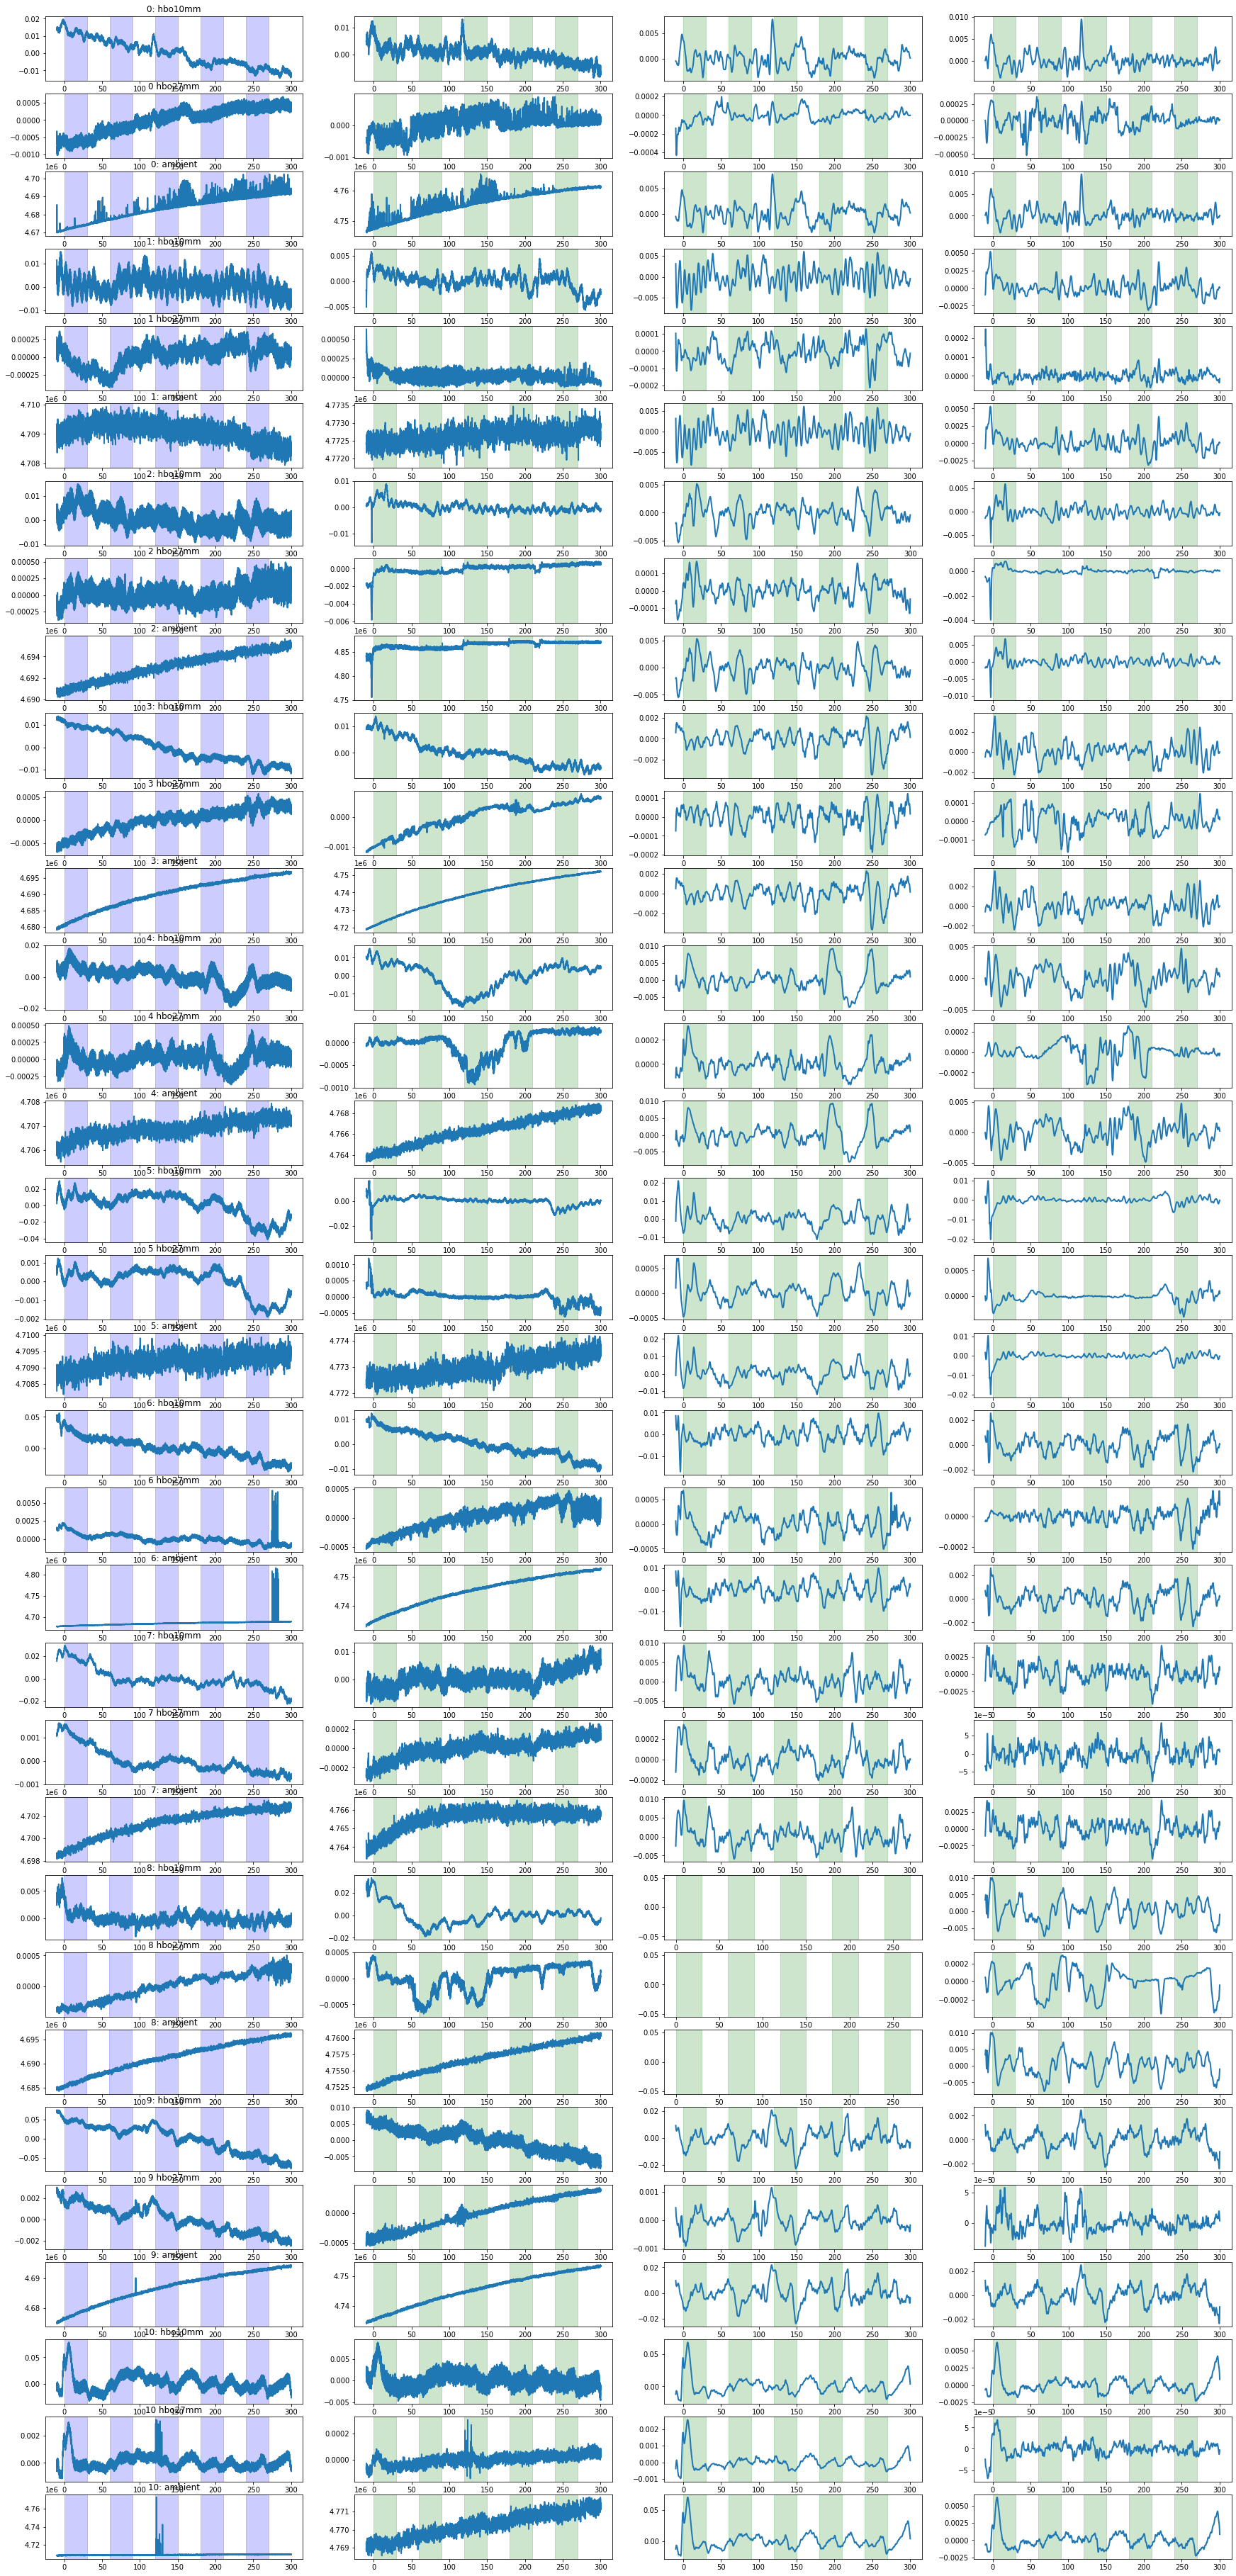

In [ ]:

fig, ax = plt.subplots(3*nrecs,4,figsize=(30, 6*nrecs))

for i in range(nrecs):
  df = recs[i]
  # display(df)

  amb = df['ambient_L'] / df['ambient_R']

  ax[3*i,0].set_title(str(i) + ": hbo10mm")
  ax[3*i,0].plot(df.timestamp, df['hbo10mm_L'], linewidth=2)
  ax[3*i,1].plot(df.timestamp, df['hbo10mm_R'], linewidth=2)
  ax[3*i,2].plot(df.timestamp, df['hbo10mm_L_filt'], linewidth=2)
  ax[3*i,3].plot(df.timestamp, df['hbo10mm_R_filt'], linewidth=2)

  ax[3*i+1,0].set_title(str(i) + " hbo27mm")
  ax[3*i+1,0].plot(df.timestamp, df['hbo27mm_L'], linewidth=2)
  ax[3*i+1,1].plot(df.timestamp, df['hbo27mm_R'], linewidth=2)
  ax[3*i+1,2].plot(df.timestamp, df['hbo27mm_L_filt'], linewidth=2)
  ax[3*i+1,3].plot(df.timestamp, df['hbo27mm_R_filt'], linewidth=2)

  ax[3*i+2,0].set_title(str(i) + ": ambient")
  ax[3*i+2,0].plot(df.timestamp, df['ambient_L'], linewidth=2)
  ax[3*i+2,1].plot(df.timestamp, df['ambient_R'], linewidth=2)
  
  ax[3*i+2,2].plot(df.timestamp, df['hbo10mm_L_filt'] + df['hbo27mm_L_filt'], linewidth=2)
  ax[3*i+2,3].plot(df.timestamp, df['hbo10mm_R_filt'] + df['hbo27mm_R_filt'], linewidth=2)

for a in range(3*nrecs):
  for b in range(4):
    for n in range(nrounds):
      c = 'green'
      if b == 0:
        if c == 'green':
          c = 'blue'
        else:
          c = 'green'

      ax[a,b].axvspan(60*n, 60*n+30, color=c, alpha=0.2)


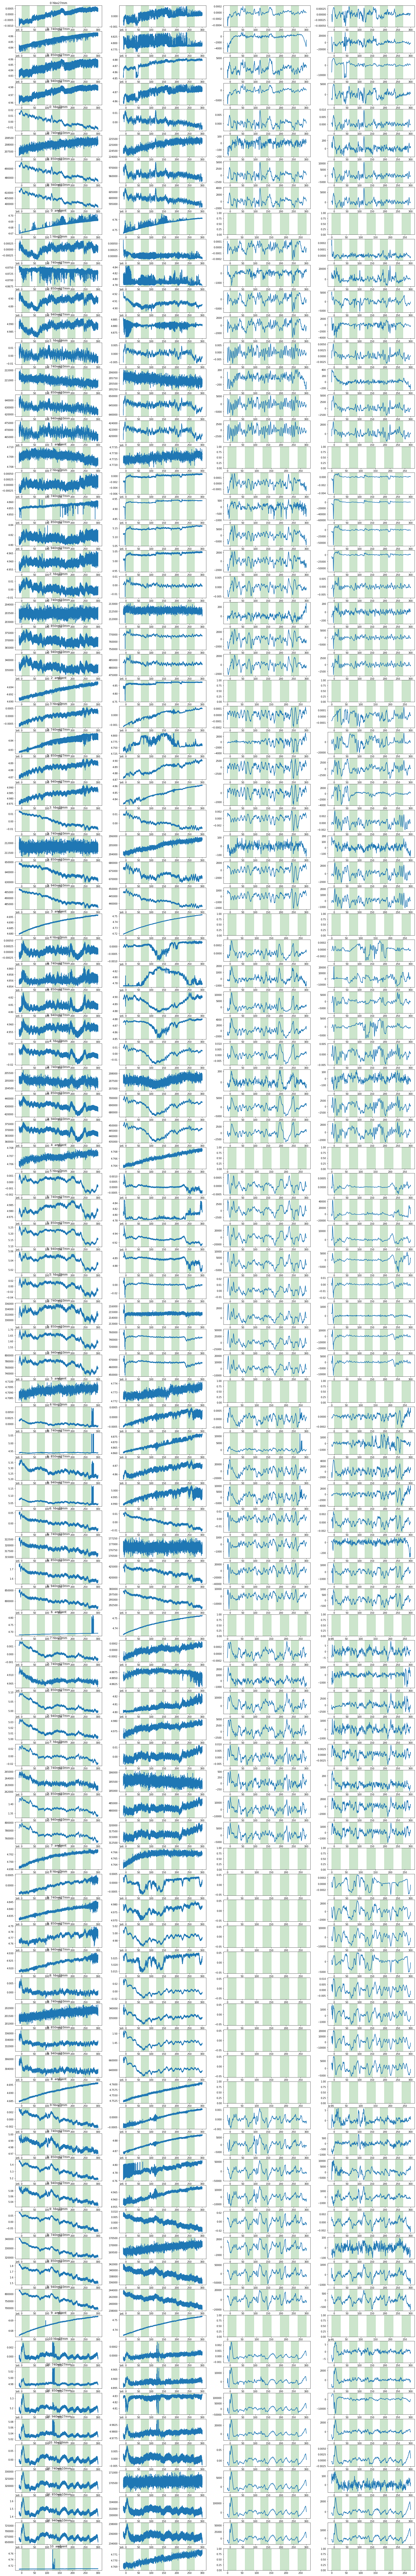

In [ ]:
fig, ax = plt.subplots(9*nrecs,4,figsize=(30, 18*nrecs))

for i in range(nrecs):
  df = recs[i]
  # display(df)

  amb = df['ambient_L'] / df['ambient_R']

  ax[9*i,0].set_title(str(i) + " hbo27mm")
  ax[9*i,0].plot(df.timestamp, df['hbo27mm_L'], linewidth=2)
  ax[9*i,1].plot(df.timestamp, df['hbo27mm_R'], linewidth=2)
  ax[9*i,2].plot(df.timestamp, df['hbo27mm_L_filt'], linewidth=2)
  ax[9*i,3].plot(df.timestamp, df['hbo27mm_R_filt'], linewidth=2)

  ax[9*i+1,0].set_title(str(i) + ": 740nm27mm")
  ax[9*i+1,0].plot(df.timestamp, df['740nm27mm_L'], linewidth=2)
  ax[9*i+1,1].plot(df.timestamp, df['740nm27mm_R'], linewidth=2)
  ax[9*i+1,2].plot(df.timestamp, df['740nm27mm_L_filt'], linewidth=2)
  ax[9*i+1,3].plot(df.timestamp, df['740nm27mm_R_filt'], linewidth=2)

  ax[9*i+2,0].set_title(str(i) + ": 850nm27mm")
  ax[9*i+2,0].plot(df.timestamp, df['850nm27mm_L'], linewidth=2)
  ax[9*i+2,1].plot(df.timestamp, df['850nm27mm_R'], linewidth=2)
  ax[9*i+2,2].plot(df.timestamp, df['850nm27mm_L_filt'], linewidth=2)
  ax[9*i+2,3].plot(df.timestamp, df['850nm27mm_R_filt'], linewidth=2)

  ax[9*i+3,0].set_title(str(i) + ": 940nm27mm")
  ax[9*i+3,0].plot(df.timestamp, df['940nm27mm_L'], linewidth=2)
  ax[9*i+3,1].plot(df.timestamp, df['940nm27mm_R'], linewidth=2)
  ax[9*i+3,2].plot(df.timestamp, df['940nm27mm_L_filt'], linewidth=2)
  ax[9*i+3,3].plot(df.timestamp, df['940nm27mm_R_filt'], linewidth=2)

  ax[9*i+4,0].set_title(str(i) + ": hbo10mm")
  ax[9*i+4,0].plot(df.timestamp, df['hbo10mm_L'], linewidth=2)
  ax[9*i+4,1].plot(df.timestamp, df['hbo10mm_R'], linewidth=2)
  ax[9*i+4,2].plot(df.timestamp, df['hbo10mm_L_filt'], linewidth=2)
  ax[9*i+4,3].plot(df.timestamp, df['hbo10mm_R_filt'], linewidth=2)

  ax[9*i+5,0].set_title(str(i) + ": 740nm10mm")
  ax[9*i+5,0].plot(df.timestamp, df['740nm10mm_L'], linewidth=2)
  ax[9*i+5,1].plot(df.timestamp, df['740nm10mm_R'], linewidth=2)
  ax[9*i+5,2].plot(df.timestamp, df['740nm10mm_L_filt'], linewidth=2)
  ax[9*i+5,3].plot(df.timestamp, df['740nm10mm_R_filt'], linewidth=2)
  
  ax[9*i+6,0].set_title(str(i) + ": 850nm10mm")
  ax[9*i+6,0].plot(df.timestamp, df['850nm10mm_L'], linewidth=2)
  ax[9*i+6,1].plot(df.timestamp, df['850nm10mm_R'], linewidth=2)
  ax[9*i+6,2].plot(df.timestamp, df['850nm10mm_L_filt'], linewidth=2)
  ax[9*i+6,3].plot(df.timestamp, df['850nm10mm_R_filt'], linewidth=2)
  
  ax[9*i+7,0].set_title(str(i) + ": 940nm10mm")
  ax[9*i+7,0].plot(df.timestamp, df['940nm10mm_L'], linewidth=2)
  ax[9*i+7,1].plot(df.timestamp, df['940nm10mm_R'], linewidth=2)
  ax[9*i+7,2].plot(df.timestamp, df['940nm10mm_L_filt'], linewidth=2)
  ax[9*i+7,3].plot(df.timestamp, df['940nm10mm_R_filt'], linewidth=2)

  ax[9*i+8,0].set_title(str(i) + ": ambient")
  ax[9*i+8,0].plot(df.timestamp, df['ambient_L'], linewidth=2)
  ax[9*i+8,1].plot(df.timestamp, df['ambient_R'], linewidth=2)
  # ax[9*i+8,2].plot(df.timestamp, df['ambient_L_filt'], linewidth=2)
  # ax[9*i+8,3].plot(df.timestamp, df['ambient_R_filt'], linewidth=2)

for a in range(9*nrecs):
  for b in range(4):
    for n in range(nrounds):
      ax[a,b].axvspan(60*n, 60*n+30, color='green', alpha=0.2)

In [ ]:
fig, ax = plt.subplots(nrecs,1,figsize=(10, nrecs*2))

for i in range(nrecs):
  df = recs[i]

  ax[i].plot(df.timestamp, df.HbO_27_L, linewidth=3)
  ax[i].plot(df.timestamp, df.HbO_27_R, linewidth=3)

  for n in range(nrounds):
    ax[i].axvspan(60*n, 60*n+30, color='green', alpha=0.2)


SyntaxError: ignored